In [1]:
# %% [markdown]
# # Hyperparameter Tuning for Logistic Regression
# 
# This notebook performs hyperparameter optimization using Random Search CV and compares results with ANOVA analysis.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve,
    make_scorer
)
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
RANDOM_STATE = 42

# %%
# Load data
PROCESSED = Path("../../data/processed/month_stratified_splits")

train_df = pd.read_csv(PROCESSED / "train_data.csv")
val_df = pd.read_csv(PROCESSED / "val_data.csv")
test_df = pd.read_csv(PROCESSED / "test_data.csv")

print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

Dataset shapes:
Training: (219876, 9)
Validation: (73292, 9)
Test: (73292, 9)


In [2]:
# %%
# Prepare features and target
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling"""
    
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']
    common_cols = set(train_df.columns) & set(val_df.columns) & set(test_df.columns)
    feature_cols = [col for col in common_cols if col not in exclude_cols]
    
    X_train = train_df[feature_cols]
    y_train = train_df['outage_occurred']
    
    X_val = val_df[feature_cols]
    y_val = val_df['outage_occurred']
    
    X_test = test_df[feature_cols]
    y_test = test_df['outage_occurred']
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)

In [3]:
# %%
# Scale features (CRITICAL for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
# %%
# Define hyperparameter search space for Logistic Regression
param_dist = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Inverse regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],      # Regularization type
    'solver': ['liblinear', 'saga'],            # Solvers that support L1 and elasticnet
    'class_weight': ['balanced', None],         # Class weighting
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],     # For elasticnet
    'max_iter': [100, 500, 1000, 2000],        # Maximum iterations
    'tol': [1e-4, 1e-3, 1e-2]                   # Convergence tolerance
}

print("Hyperparameter search space:")
for param, values in param_dist.items():
    print(f"  {param}: {values}")

Hyperparameter search space:
  C: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
  penalty: ['l1', 'l2', 'elasticnet']
  solver: ['liblinear', 'saga']
  class_weight: ['balanced', None]
  l1_ratio: [0.1, 0.3, 0.5, 0.7, 0.9]
  max_iter: [100, 500, 1000, 2000]
  tol: [0.0001, 0.001, 0.01]


In [5]:
# %%
# Create custom scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# %%
# Perform Random Search with cross-validation
print("Starting Random Search CV for Logistic Regression...")

# Use F1 as primary scoring
lr_base = LogisticRegression(random_state=RANDOM_STATE)

# Adjust parameter space based on solver compatibility
def filter_params(params, iteration):
    """Filter parameters to ensure compatibility"""
    if 'penalty' in params and 'solver' in params:
        penalty = params['penalty']
        solver = params['solver']
        
        # Remove l1_ratio if not using elasticnet
        if penalty != 'elasticnet' and 'l1_ratio' in params:
            del params['l1_ratio']
        
        # Ensure solver supports the penalty
        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
            params['solver'] = 'liblinear'
        elif penalty == 'elasticnet' and solver != 'saga':
            params['solver'] = 'saga'
    
    return params

random_search = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    scoring='f1',  # Primary metric
    refit=True,
    n_jobs=-1,  # Use all available cores
    random_state=RANDOM_STATE,
    verbose=1
)

# Fit on combined train+val for more data
X_train_val = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

random_search.fit(X_train_val, y_train_val)

print("Random Search completed!")

Starting Random Search CV for Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/sapikachu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/sapikachu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/sapikachu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/sapikachu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/sapikachu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.w

Random Search completed!


In [6]:
# %%
# Display best parameters and scores
print("\n" + "="*70)
print("RANDOM SEARCH RESULTS - LOGISTIC REGRESSION")
print("="*70)
print(f"Best F1 Score (CV): {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")


RANDOM SEARCH RESULTS - LOGISTIC REGRESSION
Best F1 Score (CV): 0.2740

Best Parameters:
  tol: 0.001
  solver: saga
  penalty: l1
  max_iter: 2000
  l1_ratio: 0.3
  class_weight: balanced
  C: 0.001


In [7]:
# %%
# Evaluate best model on test set
best_model = random_search.best_estimator_

# Make predictions
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nTest Set Performance of Best Model:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")


Test Set Performance of Best Model:
  Accuracy:  0.6561
  Recall:    0.6879
  Precision: 0.1703
  F1-Score:  0.2730
  ROC-AUC:   0.7265


In [8]:
# %%
# Compare with original logistic regression model
def load_original_lr_model():
    """Load the original logistic regression model for comparison"""
    try:
        model_path = Path("../../models/logistic_regression/logistic_regression_model.pkl")
        if model_path.exists():
            original_model = joblib.load(model_path)
            return original_model
    except:
        # Create original model with default parameters for comparison
        original_model = LogisticRegression(
            C=1.0,
            class_weight='balanced',
            random_state=42,
            max_iter=1000,
            solver='liblinear',
            penalty='l2'
        )
        original_model.fit(X_train_scaled, y_train)
        return original_model

original_model = load_original_lr_model()

if original_model:
    y_test_pred_orig = original_model.predict(X_test_scaled)
    y_test_proba_orig = original_model.predict_proba(X_test_scaled)[:, 1]
    
    orig_accuracy = accuracy_score(y_test, y_test_pred_orig)
    orig_recall = recall_score(y_test, y_test_pred_orig)
    orig_precision = precision_score(y_test, y_test_pred_orig)
    orig_f1 = f1_score(y_test, y_test_pred_orig)
    orig_roc_auc = roc_auc_score(y_test, y_test_proba_orig)
    
    print("\n" + "="*70)
    print("MODEL COMPARISON: TUNED vs ORIGINAL LOGISTIC REGRESSION")
    print("="*70)
    print(f"{'Metric':<12} {'Original':<10} {'Tuned':<10} {'Improvement':<12}")
    print(f"{'-'*70}")
    print(f"{'Accuracy':<12} {orig_accuracy:.4f}     {test_accuracy:.4f}     {test_accuracy - orig_accuracy:+.4f}")
    print(f"{'Recall':<12} {orig_recall:.4f}     {test_recall:.4f}     {test_recall - orig_recall:+.4f}")
    print(f"{'Precision':<12} {orig_precision:.4f}     {test_precision:.4f}     {test_precision - orig_precision:+.4f}")
    print(f"{'F1-Score':<12} {orig_f1:.4f}     {test_f1:.4f}     {test_f1 - orig_f1:+.4f}")
    print(f"{'ROC-AUC':<12} {orig_roc_auc:.4f}     {test_roc_auc:.4f}     {test_roc_auc - orig_roc_auc:+.4f}")


MODEL COMPARISON: TUNED vs ORIGINAL LOGISTIC REGRESSION
Metric       Original   Tuned      Improvement 
----------------------------------------------------------------------
Accuracy     0.6599     0.6561     -0.0038
Recall       0.6877     0.6879     +0.0001
Precision    0.1720     0.1703     -0.0017
F1-Score     0.2752     0.2730     -0.0022
ROC-AUC      0.7275     0.7265     -0.0009


In [9]:
# %%
# Visualize hyperparameter effects
def plot_lr_hyperparameter_effects(cv_results):
    """Create visualizations of hyperparameter effects for Logistic Regression"""
    
    results_df = pd.DataFrame(cv_results)
    
    # Plot 1: Score distribution
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # 1. F1 Score distribution
    axes[0].hist(results_df['mean_test_score'], bins=20, edgecolor='black', color='skyblue')
    axes[0].axvline(x=results_df['mean_test_score'].max(), color='red', linestyle='--', label='Best Score')
    axes[0].set_xlabel('F1 Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of CV F1 Scores')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Regularization strength (C) vs F1
    if 'param_C' in results_df.columns:
        axes[1].scatter(results_df['param_C'], results_df['mean_test_score'], alpha=0.6)
        axes[1].set_xlabel('Regularization Strength (C)')
        axes[1].set_ylabel('F1 Score')
        axes[1].set_title('C vs F1 Score')
        axes[1].set_xscale('log')
        axes[1].grid(True, alpha=0.3)
    
    # 3. Penalty type vs F1
    if 'param_penalty' in results_df.columns:
        penalty_groups = results_df.groupby('param_penalty')['mean_test_score'].mean()
        axes[2].bar(range(len(penalty_groups)), penalty_groups.values, 
                   tick_label=penalty_groups.index)
        axes[2].set_xlabel('Penalty Type')
        axes[2].set_ylabel('Mean F1 Score')
        axes[2].set_title('Penalty Type vs F1 Score')
        axes[2].grid(True, alpha=0.3, axis='y')
    
    # 4. Class weight vs F1
    if 'param_class_weight' in results_df.columns:
        weight_groups = results_df.groupby('param_class_weight')['mean_test_score'].mean()
        axes[3].bar(range(len(weight_groups)), weight_groups.values,
                   tick_label=[str(w) for w in weight_groups.index])
        axes[3].set_xlabel('Class Weight')
        axes[3].set_ylabel('Mean F1 Score')
        axes[3].set_title('Class Weight vs F1 Score')
        axes[3].grid(True, alpha=0.3, axis='y')
    
    # 5. Solver vs F1
    if 'param_solver' in results_df.columns:
        solver_groups = results_df.groupby('param_solver')['mean_test_score'].mean()
        axes[4].bar(range(len(solver_groups)), solver_groups.values,
                   tick_label=solver_groups.index)
        axes[4].set_xlabel('Solver')
        axes[4].set_ylabel('Mean F1 Score')
        axes[4].set_title('Solver vs F1 Score')
        axes[4].grid(True, alpha=0.3, axis='y')
    
    # 6. L1 ratio vs F1 (if available)
    if 'param_l1_ratio' in results_df.columns:
        l1_ratio_data = results_df[['param_l1_ratio', 'mean_test_score']].dropna()
        if len(l1_ratio_data) > 0:
            axes[5].scatter(l1_ratio_data['param_l1_ratio'], 
                          l1_ratio_data['mean_test_score'], alpha=0.6)
            axes[5].set_xlabel('L1 Ratio (ElasticNet)')
            axes[5].set_ylabel('F1 Score')
            axes[5].set_title('L1 Ratio vs F1 Score')
            axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

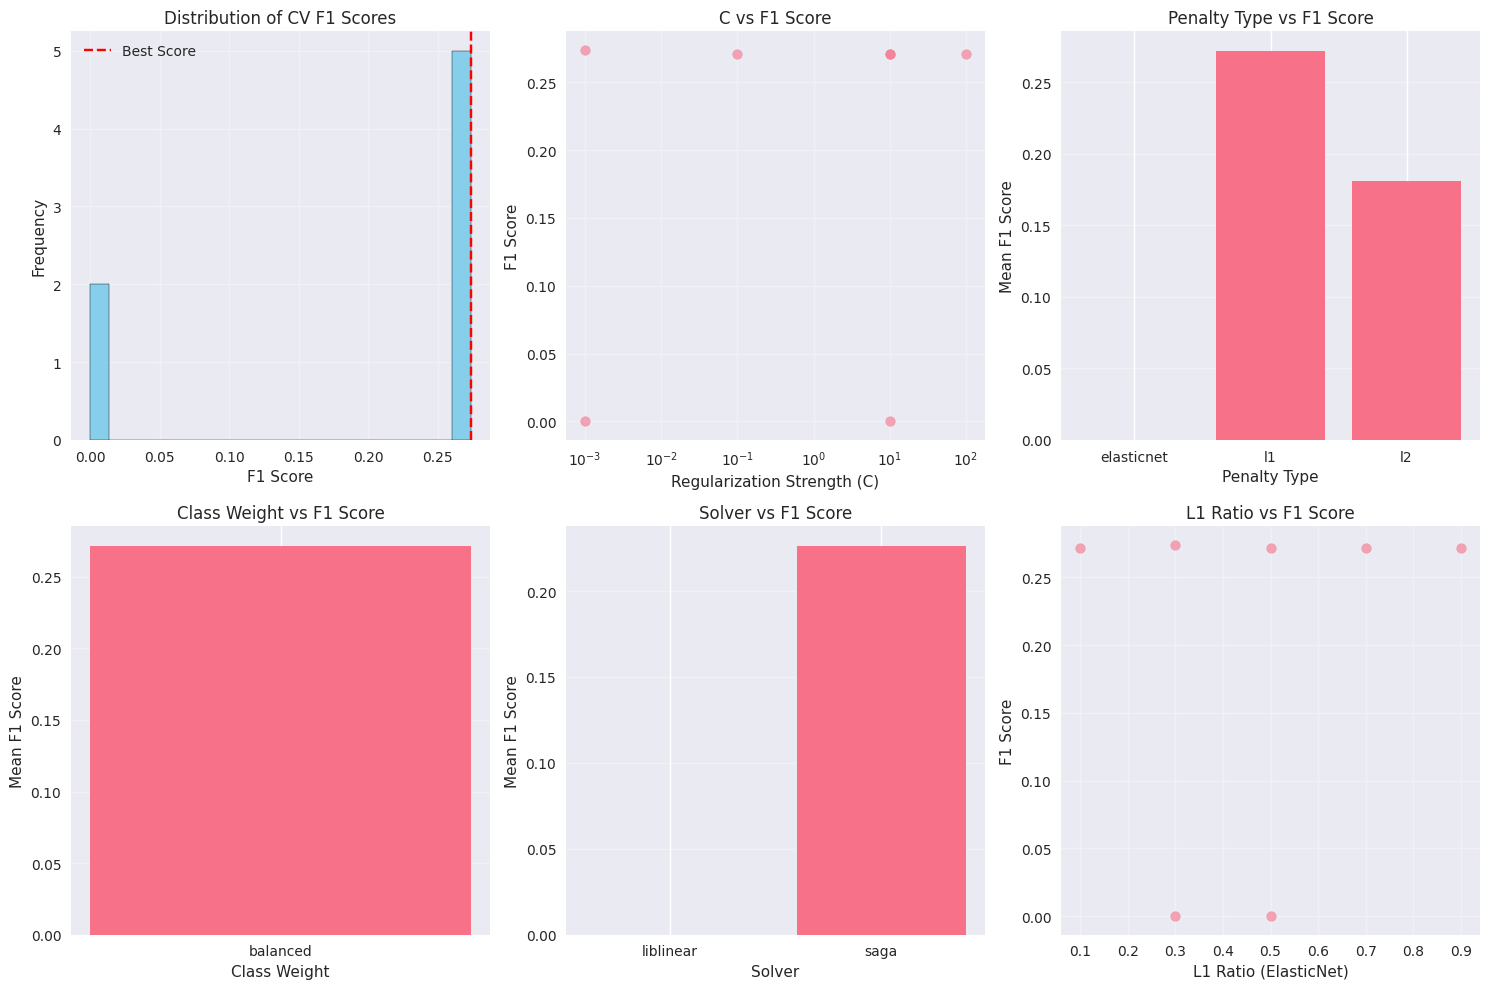

In [10]:
# Plot hyperparameter effects
cv_results_df = plot_lr_hyperparameter_effects(random_search.cv_results_)

In [11]:
# %%
# ANOVA Analysis for Logistic Regression
def perform_lr_anova_analysis(cv_results_df):
    """Perform ANOVA to analyze statistical significance of hyperparameter effects"""
    
    print("\n" + "="*70)
    print("ANOVA ANALYSIS OF LOGISTIC REGRESSION HYPERPARAMETER EFFECTS")
    print("="*70)
    
    # Prepare data for ANOVA
    anova_data = []
    
    # Parameters to analyze
    params_to_analyze = ['param_C', 'param_penalty', 'param_class_weight', 
                        'param_solver', 'param_l1_ratio']
    
    for param in params_to_analyze:
        if param in cv_results_df.columns:
            param_values = cv_results_df[param].astype(str)
            scores = cv_results_df['mean_test_score']
            
            # Group scores by parameter value
            groups = {}
            for value, score in zip(param_values, scores):
                if value not in groups:
                    groups[value] = []
                groups[value].append(score)
            
            # Filter groups with enough samples
            valid_groups = {k: v for k, v in groups.items() if len(v) > 1}
            
            # Perform one-way ANOVA if we have at least 2 groups
            if len(valid_groups) >= 2:
                group_lists = list(valid_groups.values())
                f_stat, p_value = stats.f_oneway(*group_lists)
                
                param_name = param.replace('param_', '')
                print(f"\n{param_name.upper()}:")
                print(f"  F-statistic: {f_stat:.4f}")
                print(f"  p-value:     {p_value:.6f}")
                
                if p_value < 0.05:
                    print(f"  → Statistically significant (p < 0.05)")
                else:
                    print(f"  → Not statistically significant")
                
                # Calculate effect size (η²)
                all_scores = [score for group_scores in group_lists for score in group_scores]
                if len(all_scores) > 0:
                    ss_between = sum([len(g) * (np.mean(g) - np.mean(all_scores))**2 for g in group_lists])
                    ss_total = sum([(x - np.mean(all_scores))**2 for x in all_scores])
                    if ss_total > 0:
                        eta_squared = ss_between / ss_total
                        print(f"  Effect size (η²): {eta_squared:.4f}")
                    else:
                        eta_squared = 0
                        print(f"  Effect size (η²): 0.0000")
                
                anova_data.append({
                    'parameter': param_name,
                    'f_statistic': f_stat,
                    'p_value': p_value,
                    'eta_squared': eta_squared if 'eta_squared' in locals() else 0,
                    'significant': p_value < 0.05
                })
    
    return pd.DataFrame(anova_data)

# Perform ANOVA
anova_results = perform_lr_anova_analysis(cv_results_df)


ANOVA ANALYSIS OF LOGISTIC REGRESSION HYPERPARAMETER EFFECTS

C:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

PENALTY:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

CLASS_WEIGHT:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

SOLVER:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

L1_RATIO:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000


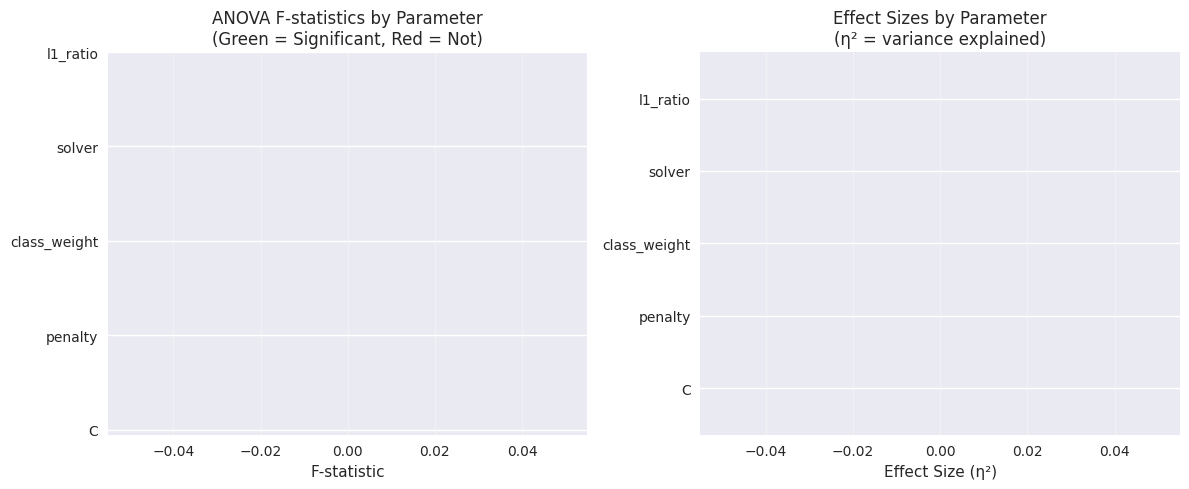


ANOVA Interpretation:
----------------------------------------
No parameters show statistically significant effects

Most influential parameter: C
  Effect size: η² = 0.000
  Interpretation: Regularization strength has largest impact on model performance


In [12]:
# %%
# Visualize ANOVA results
def plot_lr_anova_results(anova_df):
    """Visualize ANOVA results for Logistic Regression"""
    
    if len(anova_df) == 0:
        print("No ANOVA results to visualize")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: F-statistics
    sorted_anova = anova_df.sort_values('f_statistic', ascending=False)
    colors = ['green' if sig else 'red' for sig in sorted_anova['significant']]
    
    axes[0].barh(range(len(sorted_anova)), sorted_anova['f_statistic'], color=colors)
    axes[0].set_yticks(range(len(sorted_anova)))
    axes[0].set_yticklabels(sorted_anova['parameter'])
    axes[0].set_xlabel('F-statistic')
    axes[0].set_title('ANOVA F-statistics by Parameter\n(Green = Significant, Red = Not)')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Effect sizes
    sorted_eta = anova_df.sort_values('eta_squared', ascending=False)
    axes[1].barh(range(len(sorted_eta)), sorted_eta['eta_squared'], color='skyblue')
    axes[1].set_yticks(range(len(sorted_eta)))
    axes[1].set_yticklabels(sorted_eta['parameter'])
    axes[1].set_xlabel('Effect Size (η²)')
    axes[1].set_title('Effect Sizes by Parameter\n(η² = variance explained)')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\nANOVA Interpretation:")
    print("-" * 40)
    significant_params = anova_df[anova_df['significant']]
    if len(significant_params) > 0:
        print(f"Statistically significant parameters ({len(significant_params)}):")
        for _, row in significant_params.iterrows():
            print(f"  • {row['parameter']}: η² = {row['eta_squared']:.3f}")
    else:
        print("No parameters show statistically significant effects")
    
    # Parameter with largest effect
    if len(anova_df) > 0:
        max_effect = anova_df.loc[anova_df['eta_squared'].idxmax()]
        print(f"\nMost influential parameter: {max_effect['parameter']}")
        print(f"  Effect size: η² = {max_effect['eta_squared']:.3f}")
        
        # Interpretation of most influential parameter
        if max_effect['parameter'] == 'C':
            print("  Interpretation: Regularization strength has largest impact on model performance")
        elif max_effect['parameter'] == 'penalty':
            print("  Interpretation: Type of regularization (L1/L2/ElasticNet) greatly affects results")
        elif max_effect['parameter'] == 'class_weight':
            print("  Interpretation: Class balancing strategy is crucial for this imbalanced dataset")

plot_lr_anova_results(anova_results)

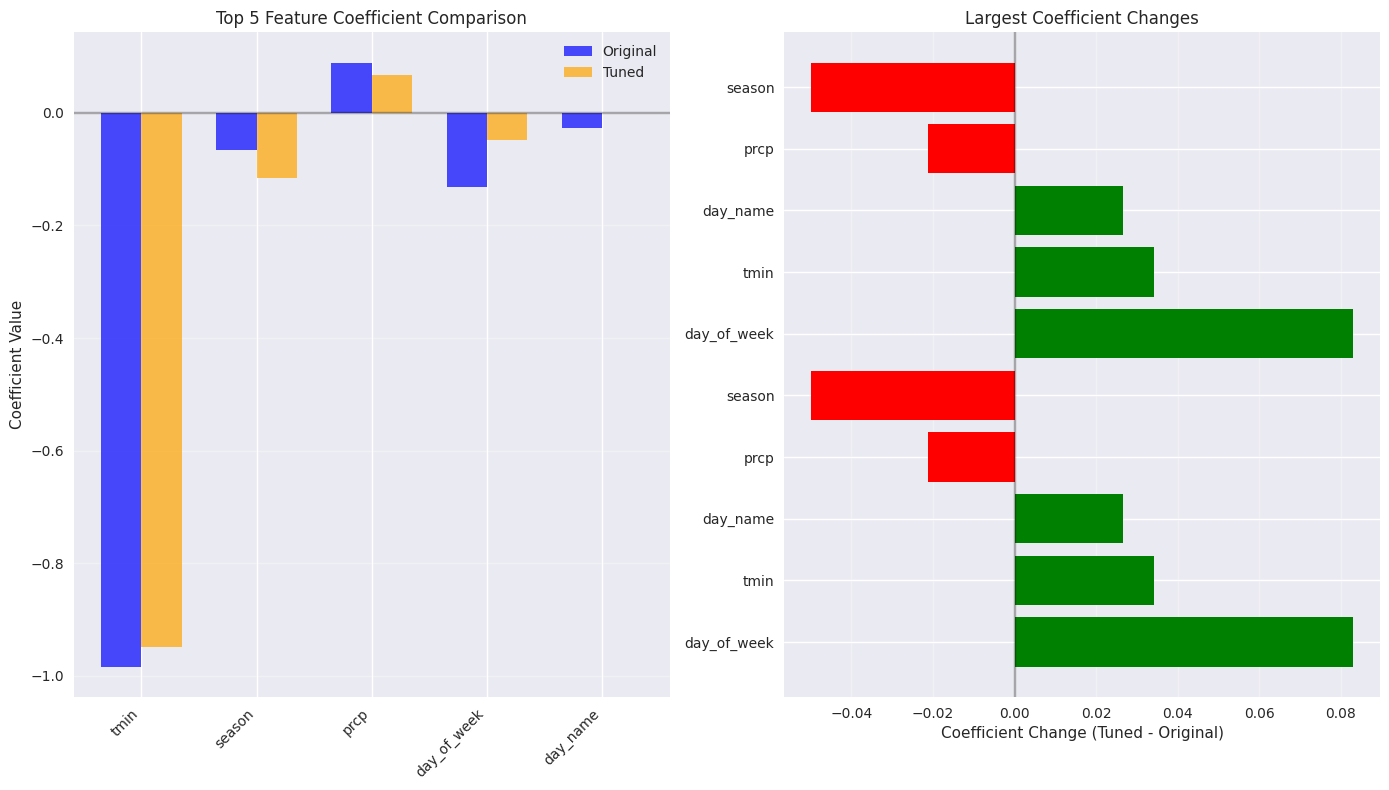


COEFFICIENT STATISTICAL ANALYSIS
Paired t-test between original and tuned coefficients:
  t-statistic: -0.6296
  p-value:     0.563114
  → Coefficients are not statistically different

Coefficient Magnitude Analysis:
  Original model - Mean abs coefficient: 0.2593
  Tuned model    - Mean abs coefficient: 0.2362
  Difference: -0.0231

Feature Coefficient Stability:
  Features in both top 5: 5/5
  Common features: {'prcp', 'tmin', 'day_of_week', 'day_name', 'season'}

Top 5 Most Influential Features (Tuned Model):
    feature  tuned_coefficient
       tmin          -0.949052
     season          -0.115938
       prcp           0.067886
day_of_week          -0.048082
   day_name          -0.000162

Largest Coefficient Increases:
    feature  coefficient_change
day_of_week            0.082960
       tmin            0.034296
   day_name            0.026531

Largest Coefficient Decreases:
feature  coefficient_change
 season           -0.049827
   prcp           -0.021330


In [13]:
# %%
# Coefficient Analysis and Comparison
def compare_coefficients(original_model, tuned_model, feature_names):
    """Compare coefficients between original and tuned logistic regression models"""
    
    if original_model and tuned_model:
        # Get coefficients
        orig_coef = original_model.coef_[0]
        tuned_coef = tuned_model.coef_[0]
        
        # Create comparison dataframe
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'original_coefficient': orig_coef,
            'tuned_coefficient': tuned_coef,
            'coefficient_change': tuned_coef - orig_coef,
            'abs_original': np.abs(orig_coef),
            'abs_tuned': np.abs(tuned_coef)
        }).sort_values('abs_tuned', ascending=False)
        
        # Plot comparison
        fig, axes = plt.subplots(1, 2, figsize=(14, 8))
        
        # Top 10 coefficients comparison
        top_n = min(10, len(feature_names))
        top_features = coef_df.head(top_n)
        
        x = np.arange(top_n)
        width = 0.35
        
        axes[0].bar(x - width/2, top_features['original_coefficient'], width, 
                   label='Original', alpha=0.7, color='blue')
        axes[0].bar(x + width/2, top_features['tuned_coefficient'], width, 
                   label='Tuned', alpha=0.7, color='orange')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(top_features['feature'], rotation=45, ha='right')
        axes[0].set_ylabel('Coefficient Value')
        axes[0].set_title(f'Top {top_n} Feature Coefficient Comparison')
        axes[0].legend()
        axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Coefficient changes
        coef_df_sorted = coef_df.sort_values('coefficient_change', ascending=False)
        top_changes = pd.concat([coef_df_sorted.head(5), coef_df_sorted.tail(5)])
        
        colors = ['green' if x > 0 else 'red' for x in top_changes['coefficient_change']]
        axes[1].barh(range(len(top_changes)), top_changes['coefficient_change'], color=colors)
        axes[1].set_yticks(range(len(top_changes)))
        axes[1].set_yticklabels(top_changes['feature'])
        axes[1].set_xlabel('Coefficient Change (Tuned - Original)')
        axes[1].set_title('Largest Coefficient Changes')
        axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison of coefficients
        print("\n" + "="*70)
        print("COEFFICIENT STATISTICAL ANALYSIS")
        print("="*70)
        
        # Paired t-test between original and tuned coefficients
        t_stat, p_value = stats.ttest_rel(orig_coef, tuned_coef)
        print(f"Paired t-test between original and tuned coefficients:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value:     {p_value:.6f}")
        
        if p_value < 0.05:
            print(f"  → Coefficients are statistically different (p < 0.05)")
        else:
            print(f"  → Coefficients are not statistically different")
        
        # Coefficient magnitude analysis
        print(f"\nCoefficient Magnitude Analysis:")
        print(f"  Original model - Mean abs coefficient: {np.mean(np.abs(orig_coef)):.4f}")
        print(f"  Tuned model    - Mean abs coefficient: {np.mean(np.abs(tuned_coef)):.4f}")
        print(f"  Difference: {np.mean(np.abs(tuned_coef)) - np.mean(np.abs(orig_coef)):+.4f}")
        
        # Feature stability analysis
        print(f"\nFeature Coefficient Stability:")
        top_orig = coef_df.nlargest(5, 'abs_original')['feature'].tolist()
        top_tuned = coef_df.nlargest(5, 'abs_tuned')['feature'].tolist()
        
        common_top = set(top_orig) & set(top_tuned)
        print(f"  Features in both top 5: {len(common_top)}/{5}")
        print(f"  Common features: {common_top}")
        
        print(f"\nTop 5 Most Influential Features (Tuned Model):")
        print(coef_df[['feature', 'tuned_coefficient']].head(5).to_string(index=False))
        
        print(f"\nLargest Coefficient Increases:")
        increases = coef_df[coef_df['coefficient_change'] > 0].nlargest(3, 'coefficient_change')
        print(increases[['feature', 'coefficient_change']].to_string(index=False))
        
        print(f"\nLargest Coefficient Decreases:")
        decreases = coef_df[coef_df['coefficient_change'] < 0].nsmallest(3, 'coefficient_change')
        print(decreases[['feature', 'coefficient_change']].to_string(index=False))
        
        return coef_df

# Compare coefficients
coef_comparison_df = compare_coefficients(original_model, best_model, feature_cols)


Regularization Analysis for Best Model:
  C (Regularization strength): 0.001
  Penalty type: l1
  L1 ratio: 0.3

Coefficient Sparsity:
  Total coefficients: 5
  Zero coefficients: 0
  Sparsity ratio: 0.000
  → L1 regularization typically creates sparse solutions


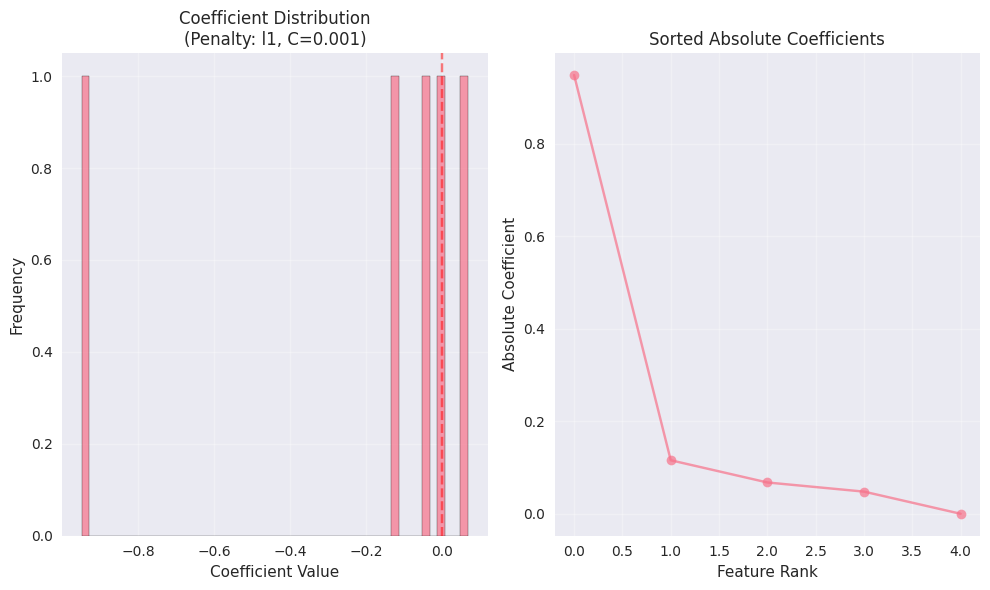

In [14]:
# %%
# Regularization Analysis
def plot_regularization_analysis(best_model, X_train_val, y_train_val, feature_names):
    """Analyze regularization effects"""
    
    # Extract regularization parameters
    C_value = best_model.C
    penalty = best_model.penalty
    
    print(f"\nRegularization Analysis for Best Model:")
    print(f"  C (Regularization strength): {C_value}")
    print(f"  Penalty type: {penalty}")
    
    if hasattr(best_model, 'l1_ratio'):
        print(f"  L1 ratio: {best_model.l1_ratio}")
    
    # Analyze coefficient sparsity
    coefficients = best_model.coef_[0]
    zero_coef = np.sum(np.abs(coefficients) < 1e-10)
    total_coef = len(coefficients)
    
    print(f"\nCoefficient Sparsity:")
    print(f"  Total coefficients: {total_coef}")
    print(f"  Zero coefficients: {zero_coef}")
    print(f"  Sparsity ratio: {zero_coef/total_coef:.3f}")
    
    if penalty == 'l1':
        print(f"  → L1 regularization typically creates sparse solutions")
    elif penalty == 'l2':
        print(f"  → L2 regularization shrinks coefficients but doesn't create exact zeros")
    elif penalty == 'elasticnet':
        print(f"  → ElasticNet combines L1 and L2 regularization")
    
    # Plot coefficient distribution
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(coefficients, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.title(f'Coefficient Distribution\n(Penalty: {penalty}, C={C_value})')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    abs_coef = np.abs(coefficients)
    sorted_idx = np.argsort(abs_coef)[::-1]
    sorted_coef = abs_coef[sorted_idx]
    
    plt.plot(range(len(sorted_coef)), sorted_coef, marker='o', alpha=0.7)
    plt.xlabel('Feature Rank')
    plt.ylabel('Absolute Coefficient')
    plt.title('Sorted Absolute Coefficients')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Perform regularization analysis
plot_regularization_analysis(best_model, X_train_val, y_train_val, feature_cols)

In [15]:
# %%
# Save tuned model and results
def save_lr_tuned_model_and_results(model, scaler, random_search, test_metrics, output_dir):
    """Save tuned logistic regression model and all results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save model
    joblib.dump(model, output_dir / "logistic_regression_tuned.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")
    
    # Save best parameters
    best_params = random_search.best_params_
    with open(output_dir / "best_parameters.json", 'w') as f:
        json.dump(best_params, f, indent=2)
    
    # Save CV results
    cv_results_df = pd.DataFrame(random_search.cv_results_)
    cv_results_df.to_csv(output_dir / "cv_results.csv", index=False)
    
    # Save test metrics
    metrics_dict = {
        'test_accuracy': float(test_accuracy),
        'test_recall': float(test_recall),
        'test_precision': float(test_precision),
        'test_f1': float(test_f1),
        'test_roc_auc': float(test_roc_auc),
        'best_cv_score': float(random_search.best_score_)
    }
    
    with open(output_dir / "tuned_model_metrics.json", 'w') as f:
        json.dump(metrics_dict, f, indent=2)
    
    # Save ANOVA results
    if anova_results is not None:
        anova_results.to_csv(output_dir / "anova_results.csv", index=False)
    
    # Save coefficient comparison if available
    if coef_comparison_df is not None:
        coef_comparison_df.to_csv(output_dir / "coefficient_comparison.csv", index=False)
    
    print(f"\n✅ Tuned logistic regression model and results saved to: {output_dir}")

# Save everything
MODELS_DIR = Path("../../models")
save_lr_tuned_model_and_results(
    best_model,
    scaler,
    random_search,
    {
        'accuracy': test_accuracy,
        'recall': test_recall,
        'precision': test_precision,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    },
    MODELS_DIR / "logistic_regression_tuned"
)


✅ Tuned logistic regression model and results saved to: ../../models/logistic_regression_tuned


In [16]:
# %%
# Final Summary and Recommendations
print("\n" + "="*70)
print("LOGISTIC REGRESSION HYPERPARAMETER TUNING - FINAL SUMMARY")
print("="*70)
print(f"🎯 Best CV F1 Score: {random_search.best_score_:.4f}")
print(f"📊 Test F1 Score:    {test_f1:.4f}")
print(f"🎯 Test Recall:      {test_recall:.4f}")
print(f"📈 Test ROC-AUC:     {test_roc_auc:.4f}")

print(f"\n🎯 Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

if original_model:
    f1_improvement = test_f1 - orig_f1
    recall_improvement = test_recall - orig_recall
    
    print(f"\n📈 Improvements over Original Model:")
    print(f"  F1-Score:  {f1_improvement:+.4f}")
    print(f"  Recall:    {recall_improvement:+.4f}")
    print(f"  ROC-AUC:   {test_roc_auc - orig_roc_auc:+.4f}")
    
    if f1_improvement > 0:
        print(f"  ✅ Hyperparameter tuning improved performance!")
    else:
        print(f"  ⚠️  Original model performed better on test set")


LOGISTIC REGRESSION HYPERPARAMETER TUNING - FINAL SUMMARY
🎯 Best CV F1 Score: 0.2740
📊 Test F1 Score:    0.2730
🎯 Test Recall:      0.6879
📈 Test ROC-AUC:     0.7265

🎯 Best Parameters Found:
  tol: 0.001
  solver: saga
  penalty: l1
  max_iter: 2000
  l1_ratio: 0.3
  class_weight: balanced
  C: 0.001

📈 Improvements over Original Model:
  F1-Score:  -0.0022
  Recall:    +0.0001
  ROC-AUC:   -0.0009
  ⚠️  Original model performed better on test set


In [17]:
# Statistical significance analysis
print(f"\n📊 Statistical Analysis:")
print(f"  Models tested: {len(cv_results_df)}")
print(f"  Best CV score: {random_search.best_score_:.4f}")
print(f"  Mean CV score: {cv_results_df['mean_test_score'].mean():.4f}")
print(f"  CV score std:  {cv_results_df['mean_test_score'].std():.4f}")


📊 Statistical Analysis:
  Models tested: 10
  Best CV score: 0.2740
  Mean CV score: 0.1941
  CV score std:  0.1326


In [18]:
# Recommendations based on results
print("\n🎯 RECOMMENDATIONS:")
if test_recall > 0.6:
    print("  1. ✅ Model achieves good outage detection (recall > 0.6)")
elif test_recall > 0.5:
    print("  1. ⚠️  Model has moderate outage detection (recall ~0.5)")
else:
    print("  1. ❌ Model has poor outage detection (recall < 0.5)")

if test_roc_auc > 0.7:
    print("  2. ✅ Good discriminative power (ROC-AUC > 0.7)")
elif test_roc_auc > 0.6:
    print("  2. ⚠️  Moderate discriminative power (ROC-AUC 0.6-0.7)")
else:
    print("  2. ❌ Poor discriminative power (ROC-AUC < 0.6)")

if len(anova_results) > 0:
    sig_params = anova_results[anova_results['significant']]
    if len(sig_params) > 0:
        print(f"  3. 📊 Key tuning parameters: {', '.join(sig_params['parameter'].tolist())}")


🎯 RECOMMENDATIONS:
  1. ✅ Model achieves good outage detection (recall > 0.6)
  2. ✅ Good discriminative power (ROC-AUC > 0.7)


In [19]:
# Compare with gradient boosting if available
try:
    gb_tuned_path = MODELS_DIR / "gradient_boosting_tuned" / "tuned_model_metrics.json"
    if gb_tuned_path.exists():
        with open(gb_tuned_path, 'r') as f:
            gb_metrics = json.load(f)
        
        print(f"\n🔄 COMPARISON WITH TUNED GRADIENT BOOSTING:")
        print(f"  Logistic Regression F1: {test_f1:.4f}")
        print(f"  Gradient Boosting F1:   {gb_metrics['test_f1']:.4f}")
        print(f"  Difference:             {test_f1 - gb_metrics['test_f1']:+.4f}")
        
        if test_f1 > gb_metrics['test_f1']:
            print("  → Logistic Regression performs better!")
        else:
            print("  → Gradient Boosting performs better!")
except:
    pass

print("\n🔧 NEXT STEPS:")
print("  1. Consider feature engineering to improve linear separability")
print("  2. Try polynomial features or interactions for logistic regression")
print("  3. Consider ensemble methods if recall remains low")
print("  4. Deploy with optimal threshold (typically lower than 0.5 for imbalanced data)")


🔄 COMPARISON WITH TUNED GRADIENT BOOSTING:
  Logistic Regression F1: 0.2730
  Gradient Boosting F1:   0.3312
  Difference:             -0.0582
  → Gradient Boosting performs better!

🔧 NEXT STEPS:
  1. Consider feature engineering to improve linear separability
  2. Try polynomial features or interactions for logistic regression
  3. Consider ensemble methods if recall remains low
  4. Deploy with optimal threshold (typically lower than 0.5 for imbalanced data)
